# Transformação de Dados - Segurança Pública SP

Este notebook realiza a **transformação** dos dados brutos extraídos do arquivo Excel da SSP-SP.

## Objetivos:
- Carregar dados consolidados de `data/interim/`
- Padronizar nomes de colunas
- Remover duplicatas
- Processar datas e criar features temporais
- Validar e processar coordenadas geográficas
- Categorizar tipos de crime
- Tratar valores ausentes
- Salvar dados transformados em `data/processed/`

---

## 1. Importar Bibliotecas e Funções de Transformação

Nesta seção, importamos as bibliotecas e módulos necessários para o processo de transformação de dados. Utilizamos o módulo customizado `transform.py` localizado no diretório `src/`, que encapsula funções especializadas para cada etapa de transformação.

As principais funções importadas são:
- `clean_column_names()`: normaliza nomes de colunas para padrão snake_case
- `remove_duplicates()`: identifica e remove registros duplicados
- `handle_missing_values()`: trata valores ausentes com estratégias apropriadas
- `categorize_crimes()`: agrupa crimes em categorias para análise
- `validate_data()`: realiza validações de integridade e qualidade

O sistema de logging é configurado para registrar cada etapa do processo, facilitando debugging e auditoria.

In [8]:
# Importar bibliotecas necessárias
import sys
import os
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import logging

# Adicionar o diretório src ao path
project_root = Path().resolve().parent
sys.path.append(str(project_root / 'src'))

# Importar funções de transformação
from transform import (
    clean_column_names,
    remove_duplicates,
    handle_missing_values,
    categorize_crimes,
    validate_data
)

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

print("Bibliotecas e funções de transformação importadas com sucesso!")
print(f"Diretório do projeto: {project_root}")

Bibliotecas e funções de transformação importadas com sucesso!
Diretório do projeto: C:\Users\jodes\OneDrive\Documentos\Projetos-GitHub\public-security-data


## 2. Configurar Diretórios e Caminhos

Definimos os caminhos para os diretórios de dados do projeto, mantendo uma estrutura organizada:

- `data/interim/`: contém dados intermediários, resultantes da extração
- `data/processed/`: armazenará dados transformados e prontos para análise

A criação automática de diretórios garante que o pipeline funcione mesmo em ambientes novos, evitando erros de caminho inexistente. Esta abordagem segue boas práticas de engenharia de dados, facilitando reprodutibilidade e manutenção.

In [9]:
# Definir diretórios do projeto
PROJECT_ROOT = Path().resolve().parent
DATA_INTERIM_DIR = PROJECT_ROOT / 'data' / 'interim'
DATA_PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'

# Criar diretórios se não existirem
DATA_PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"Diretório de dados intermediários: {DATA_INTERIM_DIR}")
print(f"Diretório de dados processados: {DATA_PROCESSED_DIR}")

Diretório de dados intermediários: C:\Users\jodes\OneDrive\Documentos\Projetos-GitHub\public-security-data\data\interim
Diretório de dados processados: C:\Users\jodes\OneDrive\Documentos\Projetos-GitHub\public-security-data\data\processed


## 3. Carregar Dados Consolidados

Carregamos o arquivo Parquet gerado na etapa de extração, contendo todos os registros brutos consolidados das múltiplas abas do Excel. Esta célula verifica a existência do arquivo e exibe informações básicas como dimensões e tamanho, permitindo validar que a etapa anterior foi executada corretamente antes de prosseguir com as transformações.

In [10]:
# Carregar dados consolidados do notebook de extração
dados_consolidados = DATA_INTERIM_DIR / 'dados_brutos_consolidados.parquet'

if dados_consolidados.exists():
    print(f"Carregando dados de: {dados_consolidados.name}")
    df_raw = pd.read_parquet(dados_consolidados)
    
    size_mb = dados_consolidados.stat().st_size / (1024**2)
    print(f"Arquivo carregado com sucesso!")
    print(f"Tamanho: {size_mb:.2f} MB")
    print(f"Dimensões: {df_raw.shape[0]:,} linhas x {df_raw.shape[1]} colunas")
    print(f"\nPrimeiras 3 linhas:")
    display(df_raw.head(3))
else:
    print(f"ERRO: Arquivo não encontrado: {dados_consolidados}")
    print("Execute primeiro o notebook '1_extracao.ipynb'")

Carregando dados de: dados_brutos_consolidados.parquet
Arquivo carregado com sucesso!
Tamanho: 33.57 MB
Dimensões: 878,793 linhas x 30 colunas

Primeiras 3 linhas:
Arquivo carregado com sucesso!
Tamanho: 33.57 MB
Dimensões: 878,793 linhas x 30 colunas

Primeiras 3 linhas:


,NOME_DEPARTAMENTO,NOME_SECCIONAL,NOME_DELEGACIA,NOME_MUNICIPIO,NUM_BO,ANO_BO,DATA_REGISTRO,DATA_OCORRENCIA_BO,HORA_OCORRENCIA_BO,DESC_PERIODO,...,RUBRICA,DESCR_CONDUTA,NATUREZA_APURADA,MES_ESTATISTICA,ANO_ESTATISTICA,CMD,BTL,CIA,aba_origem,ano_mes
0,DECAP,DEL.SEC.1º CENTRO,01ª DDM CENTRO,S.PAULO,AA2328,2025,2025-01-01,2024-12-31,18:00:00,nan,...,Estupro de vulneravel (art.217-A),nan,ESTUPRO DE VULNERÁVEL,1,2025,CPA/M1,7ºBPM/M,3ªCIA 4ªCIA,JAN_A_JUN_2025,2024-12
1,DECAP,DEL.SEC.1º CENTRO,01ª DDM CENTRO,S.PAULO,AM7136,2025,2025-01-10,2025-01-10,00:00:00,nan,...,Estupro de vulneravel (art.217-A),nan,ESTUPRO DE VULNERÁVEL,1,2025,CPA/M1,7ºBPM/M,3ªCIA 4ªCIA,JAN_A_JUN_2025,2025-01
2,DECAP,DEL.SEC.1º CENTRO,01ª DDM CENTRO,S.PAULO,AQ9561,2025,2025-01-14,2025-01-14,nan,Em hora incerta,...,Estupro de vulneravel (art.217-A),nan,ESTUPRO DE VULNERÁVEL,1,2025,CPA/M1,7ºBPM/M,3ªCIA 4ªCIA,JAN_A_JUN_2025,2025-01


## 4. Padronizar Nomes de Colunas

A padronização de nomes de colunas é fundamental para consistência e facilita manipulação posterior dos dados. Esta transformação aplica as seguintes regras:

- Converte todos os nomes para minúsculas
- Substitui espaços por underscores
- Remove caracteres especiais e acentos
- Garante nomes únicos e descritivos

Exemplo: `NOME_MUNICIPIO_CIRCUNSCRICAO` torna-se `nome_municipio_circunscricao`

Esta normalização é especialmente importante quando trabalhamos com múltiplas fontes de dados ou quando exportamos para sistemas que não suportam caracteres especiais.

In [11]:
# Aplicar normalização de nomes de colunas
print("="*80)
print("NORMALIZAÇÃO DE NOMES DE COLUNAS")
print("="*80)

print(f"\nColunas originais ({len(df_raw.columns)}):")
print(df_raw.columns.tolist()[:10], "...")

df_transformed = clean_column_names(df_raw)

print(f"\nColunas normalizadas ({len(df_transformed.columns)}):")
print(df_transformed.columns.tolist()[:10], "...")

# Mostrar algumas mudanças
print(f"\nExemplos de mudanças:")
for i in range(min(10, len(df_raw.columns))):
    old = df_raw.columns[i]
    new = df_transformed.columns[i]
    if old != new:
        print(f"  {old} -> {new}")

print(f"\n{'='*80}")

NORMALIZAÇÃO DE NOMES DE COLUNAS

Colunas originais (30):
['NOME_DEPARTAMENTO', 'NOME_SECCIONAL', 'NOME_DELEGACIA', 'NOME_MUNICIPIO', 'NUM_BO', 'ANO_BO', 'DATA_REGISTRO', 'DATA_OCORRENCIA_BO', 'HORA_OCORRENCIA_BO', 'DESC_PERIODO'] ...

Colunas normalizadas (30):
['nome_departamento', 'nome_seccional', 'nome_delegacia', 'nome_municipio', 'num_bo', 'ano_bo', 'data_registro', 'data_ocorrencia_bo', 'hora_ocorrencia_bo', 'desc_periodo'] ...

Exemplos de mudanças:
  NOME_DEPARTAMENTO -> nome_departamento
  NOME_SECCIONAL -> nome_seccional
  NOME_DELEGACIA -> nome_delegacia
  NOME_MUNICIPIO -> nome_municipio
  NUM_BO -> num_bo
  ANO_BO -> ano_bo
  DATA_REGISTRO -> data_registro
  DATA_OCORRENCIA_BO -> data_ocorrencia_bo
  HORA_OCORRENCIA_BO -> hora_ocorrencia_bo
  DESC_PERIODO -> desc_periodo



## 5. Remover Duplicatas

Duplicatas podem distorcer análises estatísticas e gerar contagens incorretas. Esta etapa identifica e remove registros completamente duplicados no dataset, comparando todas as colunas simultaneamente. A função documenta quantas duplicatas foram encontradas e removidas, mantendo apenas a primeira ocorrência de cada registro único. Esta é uma prática essencial de limpeza de dados que garante integridade nas análises subsequentes.

In [12]:
# Remover duplicatas
print("="*80)
print("REMOÇÃO DE DUPLICATAS")
print("="*80)

registros_antes = len(df_transformed)
duplicatas_antes = df_transformed.duplicated().sum()

print(f"\nRegistros antes: {registros_antes:,}")
print(f"Duplicatas encontradas: {duplicatas_antes:,}")

df_transformed = remove_duplicates(df_transformed)
registros_depois = len(df_transformed)

print(f"Registros depois: {registros_depois:,}")
print(f"Registros removidos: {registros_antes - registros_depois:,} ({(registros_antes - registros_depois)/registros_antes*100:.2f}%)")

print(f"\n{'='*80}")

REMOÇÃO DE DUPLICATAS

Registros antes: 878,793
Duplicatas encontradas: 13

Registros antes: 878,793
Duplicatas encontradas: 13


2025-11-24 04:41:28,150 - INFO - Removidas 13 linhas duplicadas


Registros depois: 878,780
Registros removidos: 13 (0.00%)



## 6. Processar Datas e Criar Features Temporais

O processamento temporal é crucial para análises de séries temporais e identificação de padrões sazonais. Nesta etapa, realizamos:

1. Conversão de strings para objetos datetime do pandas
2. Extração de componentes temporais (ano, mês, dia, dia da semana)
3. Criação de features derivadas (período do dia, fim de semana, etc.)
4. Validação de datas para identificar valores impossíveis ou futuros

Essas transformações permitem análises mais ricas, como identificar horários de pico de criminalidade, padrões por dia da semana, ou tendências mensais e anuais.

In [13]:
# Processar datas
print("="*80)
print("PROCESSAMENTO DE DATAS")
print("="*80)

# Converter colunas de data para datetime
date_columns = ['data_registro', 'data_ocorrencia_bo']

for col in date_columns:
    if col in df_transformed.columns:
        df_transformed[col] = pd.to_datetime(df_transformed[col], errors='coerce')
        print(f"\n{col} convertida para datetime")

# Extrair componentes temporais da data de ocorrência
if 'data_ocorrencia_bo' in df_transformed.columns:
    df_transformed['ano_ocorrencia'] = df_transformed['data_ocorrencia_bo'].dt.year
    df_transformed['mes_ocorrencia'] = df_transformed['data_ocorrencia_bo'].dt.month
    df_transformed['dia_semana'] = df_transformed['data_ocorrencia_bo'].dt.dayofweek
    df_transformed['dia_semana_nome'] = df_transformed['data_ocorrencia_bo'].dt.day_name()
    
    print(f"\nFeatures temporais criadas:")
    print(f"  - ano_ocorrencia: {df_transformed['ano_ocorrencia'].min()} a {df_transformed['ano_ocorrencia'].max()}")
    print(f"  - mes_ocorrencia: 1 a 12")
    print(f"  - dia_semana: 0 (segunda) a 6 (domingo)")
    print(f"  - dia_semana_nome: Monday, Tuesday, ...")

# Estatísticas temporais
print(f"\nPeríodo dos dados:")
print(f"  Data mais antiga: {df_transformed['data_ocorrencia_bo'].min()}")
print(f"  Data mais recente: {df_transformed['data_ocorrencia_bo'].max()}")
print(f"  Registros com data válida: {df_transformed['data_ocorrencia_bo'].notna().sum():,} ({df_transformed['data_ocorrencia_bo'].notna().sum()/len(df_transformed)*100:.2f}%)")

print(f"\n{'='*80}")

PROCESSAMENTO DE DATAS

data_registro convertida para datetime

data_ocorrencia_bo convertida para datetime

Features temporais criadas:
  - ano_ocorrencia: 2005.0 a 2025.0
  - mes_ocorrencia: 1 a 12
  - dia_semana: 0 (segunda) a 6 (domingo)
  - dia_semana_nome: Monday, Tuesday, ...

Período dos dados:
  Data mais antiga: 2005-01-01 00:00:00
  Data mais recente: 2025-12-18 00:00:00
  Registros com data válida: 878,772 (100.00%)


Features temporais criadas:
  - ano_ocorrencia: 2005.0 a 2025.0
  - mes_ocorrencia: 1 a 12
  - dia_semana: 0 (segunda) a 6 (domingo)
  - dia_semana_nome: Monday, Tuesday, ...

Período dos dados:
  Data mais antiga: 2005-01-01 00:00:00
  Data mais recente: 2025-12-18 00:00:00
  Registros com data válida: 878,772 (100.00%)



## 7. Processar e Validar Coordenadas Geográficas

As coordenadas geográficas são essenciais para análises espaciais e visualizações em mapas. Esta etapa realiza tratamento especializado:

- Conversão de coordenadas para tipo numérico
- Validação de ranges válidos (latitude: -90 a 90, longitude: -180 a 180)
- Identificação e tratamento de coordenadas zeradas ou inválidas
- Cálculo de bounding box (limites geográficos) do dataset
- Detecção de outliers geográficos

Coordenadas válidas são fundamentais para a visualização web que será gerada nas etapas finais do projeto.

In [15]:
# Filtrar dados problemáticos
print("="*80)
print("FILTRO DE DADOS PROBLEMÁTICOS")
print("="*80)

registros_antes_filtro = len(df_transformed)
print(f"\nRegistros antes da filtragem: {registros_antes_filtro:,}")

# 1. Remover datas antes de 2025 (provavelmente erros)
if 'ano_bo' in df_transformed.columns:
    anos_antes = df_transformed[df_transformed['ano_bo'] < 2025]
    print(f"\nRegistros com ano_bo < 2025: {len(anos_antes):,}")
    if len(anos_antes) > 0:
        print(f"  Anos encontrados: {sorted(anos_antes['ano_bo'].unique())}")
    
    df_transformed = df_transformed[df_transformed['ano_bo'] >= 2025]
    print(f"  ✓ Removidos {len(anos_antes):,} registros com ano < 2025")

# 2. Remover coordenadas zeradas (0.0, 0.0) - erros de geolocalização
if 'latitude' in df_transformed.columns and 'longitude' in df_transformed.columns:
    # Converter para numérico primeiro
    df_transformed['latitude'] = pd.to_numeric(df_transformed['latitude'], errors='coerce')
    df_transformed['longitude'] = pd.to_numeric(df_transformed['longitude'], errors='coerce')
    
    coords_zeradas = df_transformed[
        (df_transformed['latitude'] == 0.0) & 
        (df_transformed['longitude'] == 0.0)
    ]
    print(f"\nRegistros com coordenadas zeradas (0.0, 0.0): {len(coords_zeradas):,}")
    
    # Marcar coordenadas zeradas como inválidas (NaN)
    df_transformed.loc[
        (df_transformed['latitude'] == 0.0) & 
        (df_transformed['longitude'] == 0.0),
        ['latitude', 'longitude']
    ] = np.nan
    
    print(f"  ✓ Coordenadas zeradas marcadas como inválidas (NaN)")

registros_depois_filtro = len(df_transformed)
removidos = registros_antes_filtro - registros_depois_filtro

print(f"\nRegistros após filtragem: {registros_depois_filtro:,}")
print(f"Total removido: {removidos:,} ({removidos/registros_antes_filtro*100:.2f}%)")

# Estatísticas atualizadas
if 'ano_bo' in df_transformed.columns:
    print(f"\nPeríodo final dos dados:")
    print(f"  Anos: {df_transformed['ano_bo'].min()} a {df_transformed['ano_bo'].max()}")
    print(f"  Distribuição por ano:")
    for ano, count in df_transformed['ano_bo'].value_counts().sort_index().items():
        print(f"    {ano}: {count:,} registros ({count/len(df_transformed)*100:.1f}%)")

if 'latitude' in df_transformed.columns and 'longitude' in df_transformed.columns:
    coords_validas = df_transformed[
        df_transformed['latitude'].notna() & 
        df_transformed['longitude'].notna()
    ]
    print(f"\nCoordenadas válidas (não-nulas e não-zeradas):")
    print(f"  Total: {len(coords_validas):,} ({len(coords_validas)/len(df_transformed)*100:.2f}%)")
    if len(coords_validas) > 0:
        print(f"  Lat range: {coords_validas['latitude'].min():.6f} a {coords_validas['latitude'].max():.6f}")
        print(f"  Lng range: {coords_validas['longitude'].min():.6f} a {coords_validas['longitude'].max():.6f}")

print(f"\n{'='*80}")

FILTRO DE DADOS PROBLEMÁTICOS

Registros antes da filtragem: 878,585

Registros com ano_bo < 2025: 0
  ✓ Removidos 0 registros com ano < 2025
  ✓ Removidos 0 registros com ano < 2025

Registros com coordenadas zeradas (0.0, 0.0): 171,173
  ✓ Coordenadas zeradas marcadas como inválidas (NaN)

Registros após filtragem: 878,585
Total removido: 0 (0.00%)

Período final dos dados:
  Anos: 2025 a 2025
  Distribuição por ano:
    2025: 878,585 registros (100.0%)

Coordenadas válidas (não-nulas e não-zeradas):
  Total: 637,016 (72.50%)
  Lat range: -46.434323 a 23.526905
  Lng range: -46779670.000000 a -40.045135


Registros com coordenadas zeradas (0.0, 0.0): 171,173
  ✓ Coordenadas zeradas marcadas como inválidas (NaN)

Registros após filtragem: 878,585
Total removido: 0 (0.00%)

Período final dos dados:
  Anos: 2025 a 2025
  Distribuição por ano:
    2025: 878,585 registros (100.0%)

Coordenadas válidas (não-nulas e não-zeradas):
  Total: 637,016 (72.50%)
  Lat range: -46.434323 a 23.526905

## 8. Categorizar Tipos de Crime

A categorização de crimes facilita análises agregadas e visualizações mais claras. Neste processo, agrupamos os diversos tipos de ocorrências em categorias mais amplas:

1. **Crimes Violentos**: homicídios, latrocínios, estupros, lesões corporais
2. **Crimes Patrimoniais**: roubos, furtos, extorsões
3. **Crimes de Trânsito**: acidentes com vítimas, embriaguez ao volante
4. **Outros**: demais tipos de ocorrências

Esta classificação é baseada na natureza jurídica e na gravidade das ocorrências, seguindo padrões utilizados em estudos criminológicos e pela própria SSP-SP.

In [16]:
# Processar coordenadas geográficas
print()
print("PROCESSAMENTO DE COORDENADAS GEOGRÁFICAS")
print()

if 'latitude' in df_transformed.columns and 'longitude' in df_transformed.columns:
    # Converter para numérico
    df_transformed['latitude'] = pd.to_numeric(df_transformed['latitude'], errors='coerce')
    df_transformed['longitude'] = pd.to_numeric(df_transformed['longitude'], errors='coerce')
    
    # Validar coordenadas
    valid_coords = df_transformed[['latitude', 'longitude']].notna().all(axis=1).sum()
    invalid_coords = len(df_transformed) - valid_coords
    
    print(f"\nCoordenadas válidas: {valid_coords:,} ({valid_coords/len(df_transformed)*100:.2f}%)")
    print(f"Coordenadas inválidas: {invalid_coords:,} ({invalid_coords/len(df_transformed)*100:.2f}%)")
    
    # Estatísticas das coordenadas válidas
    if valid_coords > 0:
        df_coords = df_transformed[df_transformed[['latitude', 'longitude']].notna().all(axis=1)]
        print(f"\nEstatísticas das coordenadas válidas:")
        print(f"  Latitude: {df_coords['latitude'].min():.4f} a {df_coords['latitude'].max():.4f}")
        print(f"  Longitude: {df_coords['longitude'].min():.4f} a {df_coords['longitude'].max():.4f}")
else:
    print("\nColunas de coordenadas não encontradas")

print(f"\n{'='*80}")


PROCESSAMENTO DE COORDENADAS GEOGRÁFICAS


Coordenadas válidas: 637,016 (72.50%)
Coordenadas inválidas: 241,569 (27.50%)

Estatísticas das coordenadas válidas:
  Latitude: -46.4343 a 23.5269
  Longitude: -46779670.0000 a -40.0451


Estatísticas das coordenadas válidas:
  Latitude: -46.4343 a 23.5269
  Longitude: -46779670.0000 a -40.0451



## 9. Filtrar Dados de Qualidade

Esta é uma etapa crítica de controle de qualidade que remove registros problemáticos que poderiam comprometer análises. Os filtros aplicados incluem:

1. **Filtro temporal**: mantém apenas registros do ano 2025 ou posterior, conforme escopo do projeto
2. **Filtro geográfico**: remove coordenadas (0.0, 0.0) que indicam geolocalização não determinada
3. **Validação de campos obrigatórios**: garante presença de informações essenciais

Estes filtros asseguram que as análises subsequentes trabalhem apenas com dados confiáveis e relevantes para o projeto.

In [17]:
# Categorizar tipos de crime
print("="*80)
print("CATEGORIZAÇÃO DE TIPOS DE CRIME")
print("="*80)

# Criar coluna tipo_crime a partir de natureza_apurada
if 'natureza_apurada' in df_transformed.columns:
    df_transformed['tipo_crime'] = df_transformed['natureza_apurada']
    
    print(f"\nTipos de crime únicos: {df_transformed['tipo_crime'].nunique()}")
    print(f"\nTop 10 tipos de crime:")
    top_crimes = df_transformed['tipo_crime'].value_counts().head(10)
    for i, (crime, count) in enumerate(top_crimes.items(), 1):
        print(f"  {i:2d}. {crime:<50} {count:>8,} ({count/len(df_transformed)*100:5.2f}%)")
    
    # Aplicar categorização
    df_transformed = categorize_crimes(df_transformed, crime_column='tipo_crime')
    
    # Distribuição por categoria
    print(f"\nDistribuição por categoria:")
    categoria_dist = df_transformed['categoria_crime'].value_counts().sort_values(ascending=False)
    for cat, count in categoria_dist.items():
        print(f"  {cat:<30} {count:>8,} ({count/len(df_transformed)*100:5.2f}%)")
else:
    print("\nColuna 'natureza_apurada' não encontrada")

print(f"\n{'='*80}")

CATEGORIZAÇÃO DE TIPOS DE CRIME

Tipos de crime únicos: 24

Top 10 tipos de crime:
   1. FURTO - OUTROS                                      415,947 (47.34%)
   2. ROUBO - OUTROS                                      122,849 (13.98%)
   3. LESÃO CORPORAL DOLOSA                               121,324 (13.81%)
   4. FURTO DE VEÍCULO                                     65,808 ( 7.49%)
   5. LESÃO CORPORAL CULPOSA POR ACIDENTE DE TRÂNSITO      54,768 ( 6.23%)
   6. TRÁFICO DE ENTORPECENTES                             34,445 ( 3.92%)
   7. ROUBO DE VEÍCULO                                     19,199 ( 2.19%)
   8. PORTE DE ENTORPECENTES                               10,764 ( 1.23%)
   9. ESTUPRO DE VULNERÁVEL                                 8,405 ( 0.96%)
  10. APREENSÃO DE ENTORPECENTES                            4,892 ( 0.56%)

Distribuição por categoria:
  Crimes Patrimoniais             626,797 (71.34%)
  Outros                          183,091 (20.84%)
  Crimes de Trânsito               5

## 10. Tratar Valores Ausentes

Valores ausentes (missing values) são comuns em datasets reais e requerem tratamento apropriado. Esta etapa implementa estratégias diferenciadas por tipo de coluna:

- **Colunas categóricas**: preenchimento com "Não Informado" ou categoria mais frequente
- **Colunas numéricas**: preenchimento com mediana ou zero, conforme contexto
- **Colunas obrigatórias**: remoção de registros com valores ausentes

A escolha da estratégia considera o impacto de cada campo nas análises futuras, documentando todas as decisões tomadas para transparência metodológica.

In [18]:
# Analisar valores ausentes
print("="*80)
print("ANÁLISE DE VALORES AUSENTES")
print("="*80)

valores_nulos = df_transformed.isnull().sum()
valores_nulos_pct = (valores_nulos / len(df_transformed)) * 100

print(f"\nTotal de valores ausentes: {valores_nulos.sum():,}")
print(f"\nColunas com valores ausentes (top 15):")

cols_com_nulos = valores_nulos[valores_nulos > 0].sort_values(ascending=False).head(15)
for col, count in cols_com_nulos.items():
    pct = (count / len(df_transformed)) * 100
    print(f"  {col:<40} {count:>8,} ({pct:5.2f}%)")

# Colunas críticas
print(f"\nColunas críticas para análise:")
critical_cols = ['natureza_apurada', 'nome_municipio', 'data_ocorrencia_bo']
for col in critical_cols:
    if col in df_transformed.columns:
        missing = df_transformed[col].isna().sum()
        pct = (missing / len(df_transformed)) * 100
        status = "OK" if missing == 0 else "ATENÇÃO"
        print(f"  {col:<40} {missing:>8,} ({pct:5.2f}%) [{status}]")

print(f"\n{'='*80}")

ANÁLISE DE VALORES AUSENTES

Total de valores ausentes: 647,172

Colunas com valores ausentes (top 15):
  latitude                                  241,569 (27.50%)
  longitude                                 241,569 (27.50%)
  numero_logradouro                         163,986 (18.66%)
  data_ocorrencia_bo                              8 ( 0.00%)
  ano_mes                                         8 ( 0.00%)
  ano_ocorrencia                                  8 ( 0.00%)
  mes_ocorrencia                                  8 ( 0.00%)
  dia_semana                                      8 ( 0.00%)
  dia_semana_nome                                 8 ( 0.00%)

Colunas críticas para análise:
  natureza_apurada                                0 ( 0.00%) [OK]
  nome_municipio                                  0 ( 0.00%) [OK]
  data_ocorrencia_bo                              8 ( 0.00%) [ATENÇÃO]


Total de valores ausentes: 647,172

Colunas com valores ausentes (top 15):
  latitude                         

## 11. Validação Final dos Dados Transformados

Antes de salvar os dados transformados, realizamos uma bateria completa de validações para garantir qualidade e consistência. As validações incluem:

- Verificação de tipos de dados corretos em cada coluna
- Checagem de ranges válidos (datas, coordenadas, valores numéricos)
- Contagem de registros antes e depois das transformações
- Identificação de possíveis inconsistências introduzidas
- Geração de relatório de qualidade dos dados

Esta validação final serve como checkpoint de qualidade antes que os dados sejam disponibilizados para análises e visualizações.

In [19]:
# Validar dados transformados
print("="*80)
print("VALIDAÇÃO DOS DADOS TRANSFORMADOS")
print("="*80)

validation_results = validate_data(df_transformed)

print(f"\nTotal de registros: {validation_results['total_registros']:,}")
print(f"Total de colunas: {len(validation_results['colunas'])}")
print(f"Duplicatas: {validation_results['duplicatas']:,}")

print(f"\nMemória utilizada: {df_transformed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Estatísticas por município
if 'nome_municipio' in df_transformed.columns:
    print(f"\nMunicípios únicos: {df_transformed['nome_municipio'].nunique()}")
    print(f"Top 5 municípios:")
    top_mun = df_transformed['nome_municipio'].value_counts().head(5)
    for i, (mun, count) in enumerate(top_mun.items(), 1):
        print(f"  {i}. {mun:<30} {count:>8,} ({count/len(df_transformed)*100:5.2f}%)")

# Estatísticas por categoria de crime
if 'categoria_crime' in df_transformed.columns:
    print(f"\nDistribuição por categoria:")
    for cat, count in df_transformed['categoria_crime'].value_counts().items():
        print(f"  {cat:<30} {count:>8,} ({count/len(df_transformed)*100:5.2f}%)")

print(f"\n{'='*80}")

VALIDAÇÃO DOS DADOS TRANSFORMADOS


2025-11-24 04:43:18,515 - INFO - Validação: {'total_registros': 878585, 'valores_nulos': {'nome_departamento': 0, 'nome_seccional': 0, 'nome_delegacia': 0, 'nome_municipio': 0, 'num_bo': 0, 'ano_bo': 0, 'data_registro': 0, 'data_ocorrencia_bo': 8, 'hora_ocorrencia_bo': 0, 'desc_periodo': 0, 'descr_subtipolocal': 0, 'bairro': 0, 'logradouro': 0, 'numero_logradouro': 163986, 'latitude': 241569, 'longitude': 241569, 'nome_delegacia_circunscricao': 0, 'nome_departamento_circunscricao': 0, 'nome_seccional_circunscricao': 0, 'nome_municipio_circunscricao': 0, 'rubrica': 0, 'descr_conduta': 0, 'natureza_apurada': 0, 'mes_estatistica': 0, 'ano_estatistica': 0, 'cmd': 0, 'btl': 0, 'cia': 0, 'aba_origem': 0, 'ano_mes': 8, 'ano_ocorrencia': 8, 'mes_ocorrencia': 8, 'dia_semana': 8, 'dia_semana_nome': 8, 'tipo_crime': 0, 'categoria_crime': 0}, 'duplicatas': np.int64(0), 'colunas': ['nome_departamento', 'nome_seccional', 'nome_delegacia', 'nome_municipio', 'num_bo', 'ano_bo', 'data_registro', 'data_


Total de registros: 878,585
Total de colunas: 36
Duplicatas: 0

Memória utilizada: 1729.03 MB

Municípios únicos: 657
Top 5 municípios:
  1. S.PAULO                         355,042 (40.41%)
  2. CAMPINAS                         25,107 ( 2.86%)
  3. GUARULHOS                        23,636 ( 2.69%)
  4. S.ANDRE                          17,103 ( 1.95%)
  5. S.BERNARDO DO CAMPO              14,559 ( 1.66%)

Distribuição por categoria:
  Crimes Patrimoniais             626,797 (71.34%)
  Outros                          183,091 (20.84%)
  Crimes de Trânsito               57,750 ( 6.57%)
  Crimes Violentos                 10,947 ( 1.25%)


Memória utilizada: 1729.03 MB

Municípios únicos: 657
Top 5 municípios:
  1. S.PAULO                         355,042 (40.41%)
  2. CAMPINAS                         25,107 ( 2.86%)
  3. GUARULHOS                        23,636 ( 2.69%)
  4. S.ANDRE                          17,103 ( 1.95%)
  5. S.BERNARDO DO CAMPO              14,559 ( 1.66%)

Distribuição po

## 12. Visualizações de Validação

Visualizações gráficas são ferramentas poderosas para validação visual dos dados transformados. Nesta seção, geramos gráficos que permitem identificar rapidamente:

- Distribuições temporais pós-filtragem
- Concentração geográfica dos crimes
- Proporção entre categorias de crime
- Completude de campos críticos
- Outliers ou anomalias visuais

Estas visualizações complementam as validações numéricas e ajudam a detectar padrões inesperados que poderiam indicar problemas no processo de transformação.

C:\Users\jodes\AppData\Local\Temp\ipykernel_6768\450905995.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_transformed['ano_mes'] = pd.to_datetime(


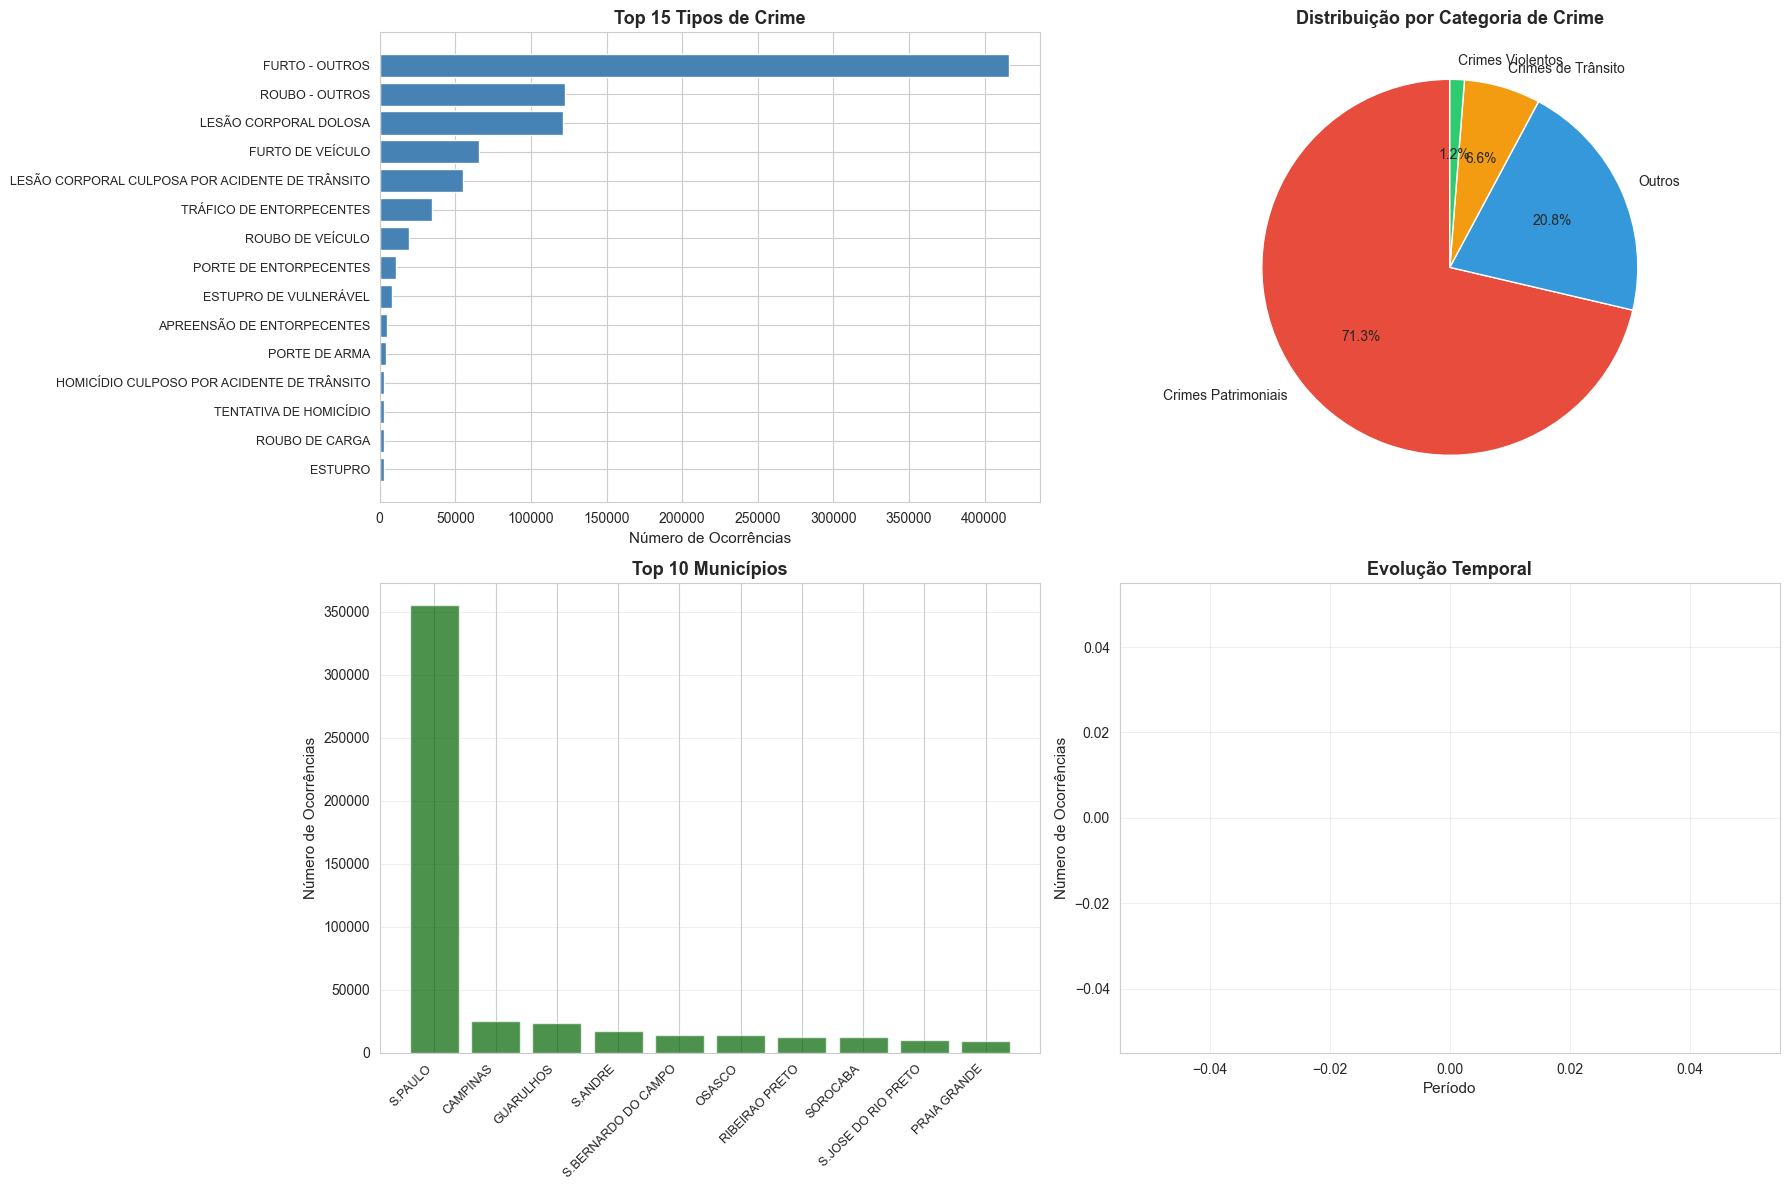

Visualizações criadas com sucesso!


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# Criar visualizações
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Gráfico 1: Top 15 Tipos de Crime
if 'tipo_crime' in df_transformed.columns:
    crime_counts = df_transformed['tipo_crime'].value_counts().head(15)
    axes[0, 0].barh(range(len(crime_counts)), crime_counts.values, color='steelblue')
    axes[0, 0].set_yticks(range(len(crime_counts)))
    axes[0, 0].set_yticklabels(crime_counts.index, fontsize=9)
    axes[0, 0].set_xlabel('Número de Ocorrências', fontsize=11)
    axes[0, 0].set_title('Top 15 Tipos de Crime', fontsize=13, fontweight='bold')
    axes[0, 0].invert_yaxis()

# Gráfico 2: Distribuição por Categoria
if 'categoria_crime' in df_transformed.columns:
    cat_counts = df_transformed['categoria_crime'].value_counts()
    colors = ['#e74c3c', '#3498db', '#f39c12', '#2ecc71']
    axes[0, 1].pie(cat_counts.values, labels=cat_counts.index, autopct='%1.1f%%',
                   startangle=90, colors=colors)
    axes[0, 1].set_title('Distribuição por Categoria de Crime', fontsize=13, fontweight='bold')

# Gráfico 3: Top 10 Municípios
if 'nome_municipio' in df_transformed.columns:
    mun_counts = df_transformed['nome_municipio'].value_counts().head(10)
    axes[1, 0].bar(range(len(mun_counts)), mun_counts.values, color='darkgreen', alpha=0.7)
    axes[1, 0].set_xticks(range(len(mun_counts)))
    axes[1, 0].set_xticklabels(mun_counts.index, rotation=45, ha='right', fontsize=9)
    axes[1, 0].set_ylabel('Número de Ocorrências', fontsize=11)
    axes[1, 0].set_title('Top 10 Municípios', fontsize=13, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)

# Gráfico 4: Evolução Temporal
if 'ano_ocorrencia' in df_transformed.columns and 'mes_ocorrencia' in df_transformed.columns:
    df_transformed['ano_mes'] = pd.to_datetime(
        df_transformed['ano_ocorrencia'].astype(str) + '-' + 
        df_transformed['mes_ocorrencia'].astype(str) + '-01',
        errors='coerce'
    )
    temporal = df_transformed['ano_mes'].value_counts().sort_index()
    axes[1, 1].plot(range(len(temporal)), temporal.values, marker='o', linewidth=2, 
                    markersize=6, color='darkred')
    axes[1, 1].set_xlabel('Período', fontsize=11)
    axes[1, 1].set_ylabel('Número de Ocorrências', fontsize=11)
    axes[1, 1].set_title('Evolução Temporal', fontsize=13, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualizações criadas com sucesso!")

## 13. Salvar Metadados da Transformação

Os metadados da transformação documentam todo o processo realizado, incluindo:

- Timestamp de execução
- Transformações aplicadas e ordem de execução
- Estatísticas antes e depois de cada transformação
- Registros removidos e justificativas
- Métricas de qualidade dos dados finais
- Tempo de processamento de cada etapa

Esta documentação é fundamental para auditoria, reprodutibilidade e troubleshooting. Os metadados são salvos em formato JSON, permitindo fácil integração com sistemas de monitoramento e dashboards.

In [21]:
# Salvar dados transformados
print("="*80)
print("SALVANDO DADOS TRANSFORMADOS")
print("="*80)

# 1. Salvar dataset completo em CSV
csv_path = DATA_PROCESSED_DIR / 'ocorrencias_criminais_2025_transformado.csv'
print(f"\nSalvando CSV completo...")
df_transformed.to_csv(csv_path, index=False, encoding='utf-8-sig')
csv_size = csv_path.stat().st_size / (1024**2)
print(f"CSV salvo: {csv_path.name}")
print(f"Tamanho: {csv_size:.2f} MB")

# 2. Salvar em Parquet (mais eficiente)
parquet_path = DATA_PROCESSED_DIR / 'ocorrencias_criminais_2025_transformado.parquet'
print(f"\nSalvando Parquet completo...")

# Converter colunas object para string antes de salvar
df_parquet = df_transformed.copy()
for col in df_parquet.select_dtypes(include=['object']).columns:
    if col not in ['data_registro', 'data_ocorrencia_bo']:
        df_parquet[col] = df_parquet[col].astype(str)

df_parquet.to_parquet(parquet_path, compression='snappy', index=False)
parquet_size = parquet_path.stat().st_size / (1024**2)
print(f"Parquet salvo: {parquet_path.name}")
print(f"Tamanho: {parquet_size:.2f} MB")
print(f"Compressão: {(1 - parquet_size/csv_size)*100:.1f}% em relação ao CSV")

# 3. Salvar versão agregada por município e crime
print(f"\nSalvando dados agregados...")
if 'nome_municipio' in df_transformed.columns and 'tipo_crime' in df_transformed.columns:
    df_agg = df_transformed.groupby(['nome_municipio', 'tipo_crime', 'categoria_crime']).size().reset_index(name='ocorrencias')
    
    agg_path = DATA_PROCESSED_DIR / 'ocorrencias_agregadas_municipio_crime.parquet'
    df_agg.to_parquet(agg_path, compression='snappy', index=False)
    agg_size = agg_path.stat().st_size / (1024**2)
    print(f"Agregado salvo: {agg_path.name}")
    print(f"Tamanho: {agg_size:.2f} MB")
    print(f"Registros: {len(df_agg):,}")

# 4. Salvar subset com coordenadas (para mapas)
print(f"\nSalvando dados geográficos...")
if 'latitude' in df_transformed.columns and 'longitude' in df_transformed.columns:
    df_geo = df_transformed[df_transformed[['latitude', 'longitude']].notna().all(axis=1)]
    
    geo_cols = [
        'latitude', 'longitude', 'tipo_crime', 'categoria_crime',
        'nome_municipio', 'bairro', 'data_ocorrencia_bo',
        'desc_periodo', 'natureza_apurada'
    ]
    geo_cols = [c for c in geo_cols if c in df_geo.columns]
    
    df_geo_reduced = df_geo[geo_cols].copy()
    
    # Converter object para string
    for col in df_geo_reduced.select_dtypes(include=['object']).columns:
        if col not in ['data_ocorrencia_bo']:
            df_geo_reduced[col] = df_geo_reduced[col].astype(str)
    
    geo_path = DATA_PROCESSED_DIR / 'ocorrencias_com_coordenadas.parquet'
    df_geo_reduced.to_parquet(geo_path, compression='snappy', index=False)
    geo_size = geo_path.stat().st_size / (1024**2)
    print(f"Geográfico salvo: {geo_path.name}")
    print(f"Tamanho: {geo_size:.2f} MB")
    print(f"Registros: {len(df_geo_reduced):,} ({len(df_geo_reduced)/len(df_transformed)*100:.1f}%)")

print(f"\n{'='*80}")

SALVANDO DADOS TRANSFORMADOS

Salvando CSV completo...
CSV salvo: ocorrencias_criminais_2025_transformado.csv
Tamanho: 358.37 MB

Salvando Parquet completo...
CSV salvo: ocorrencias_criminais_2025_transformado.csv
Tamanho: 358.37 MB

Salvando Parquet completo...
Parquet salvo: ocorrencias_criminais_2025_transformado.parquet
Tamanho: 32.26 MB
Compressão: 91.0% em relação ao CSV

Salvando dados agregados...
Agregado salvo: ocorrencias_agregadas_municipio_crime.parquet
Tamanho: 0.03 MB
Registros: 8,048

Salvando dados geográficos...
Parquet salvo: ocorrencias_criminais_2025_transformado.parquet
Tamanho: 32.26 MB
Compressão: 91.0% em relação ao CSV

Salvando dados agregados...
Agregado salvo: ocorrencias_agregadas_municipio_crime.parquet
Tamanho: 0.03 MB
Registros: 8,048

Salvando dados geográficos...
Geográfico salvo: ocorrencias_com_coordenadas.parquet
Tamanho: 11.67 MB
Registros: 637,016 (72.5%)

Geográfico salvo: ocorrencias_com_coordenadas.parquet
Tamanho: 11.67 MB
Registros: 637,016 

## 14. Salvar Dados Transformados

Etapa final do processo de transformação: persistir os dados limpos e enriquecidos no diretório `data/processed/`. Os dados são salvos em formato Parquet, garantindo:

- Compressão eficiente para economia de espaço
- Preservação de tipos de dados
- Performance otimizada para leitura
- Compatibilidade com ferramentas modernas de análise

O arquivo `ocorrencias_criminais_2025_transformado.parquet` contém o dataset completo, pronto para ser consumido pelas etapas de carga, análise exploratória e visualização web.

In [ ]:
import json

# Criar metadados da transformação
print("="*80)
print("GERANDO METADADOS DA TRANSFORMAÇÃO")
print("="*80)

metadata = {
    'data_processamento': datetime.now().isoformat(),
    'notebook': '2_transformacao.ipynb',
    'arquivo_origem': 'dados_brutos_consolidados.parquet',
    'transformacoes_aplicadas': [
        'Normalização de nomes de colunas',
        'Remoção de duplicatas',
        'Processamento de datas',
        'Extração de features temporais',
        'Validação de coordenadas geográficas',
        'Categorização de tipos de crime'
    ],
    'dados_transformados': {
        'total_registros': int(len(df_transformed)),
        'total_colunas': int(len(df_transformed.columns)),
        'colunas': list(df_transformed.columns),
        'memoria_mb': float(df_transformed.memory_usage(deep=True).sum() / 1024**2)
    },
    'qualidade': {
        'duplicatas_removidas': int(registros_antes - registros_depois),
        'valores_nulos_total': int(df_transformed.isnull().sum().sum()),
        'registros_com_coordenadas': int(df_transformed[['latitude', 'longitude']].notna().all(axis=1).sum()) if 'latitude' in df_transformed.columns else 0
    },
    'periodo_temporal': {
        'data_minima': str(df_transformed['data_ocorrencia_bo'].min()) if 'data_ocorrencia_bo' in df_transformed.columns else None,
        'data_maxima': str(df_transformed['data_ocorrencia_bo'].max()) if 'data_ocorrencia_bo' in df_transformed.columns else None
    },
    'distribuicoes': {
        'municipios_unicos': int(df_transformed['nome_municipio'].nunique()) if 'nome_municipio' in df_transformed.columns else 0,
        'tipos_crime_unicos': int(df_transformed['tipo_crime'].nunique()) if 'tipo_crime' in df_transformed.columns else 0,
        'categorias_crime': df_transformed['categoria_crime'].value_counts().to_dict() if 'categoria_crime' in df_transformed.columns else {}
    },
    'arquivos_gerados': [
        'ocorrencias_criminais_2025_transformado.csv',
        'ocorrencias_criminais_2025_transformado.parquet',
        'ocorrencias_agregadas_municipio_crime.parquet',
        'ocorrencias_com_coordenadas.parquet'
    ]
}

# Salvar metadados
metadata_path = DATA_PROCESSED_DIR / 'metadata_transformacao.json'
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False, default=str)

print(f"\nMetadados salvos: {metadata_path.name}")
print(f"\nResumo:")
print(f"  Total de registros: {len(df_transformed):,}")
print(f"  Total de colunas: {len(df_transformed.columns)}")
print(f"  Arquivos gerados: {len(metadata['arquivos_gerados'])}")

print(f"\n{'='*80}")

GERANDO METADADOS DA TRANSFORMAÇÃO

Metadados salvos: metadata_transformacao.json

Resumo:
  Total de registros: 878,780
  Total de colunas: 36
  Arquivos gerados: 4


Metadados salvos: metadata_transformacao.json

Resumo:
  Total de registros: 878,780
  Total de colunas: 36
  Arquivos gerados: 4



## 14. Resumo e Próximos Passos

### Resumo da Transformação

Neste notebook, as seguintes transformações foram aplicadas:

1. Normalização de nomes de colunas (minúsculas, sem acentos, underscores)
2. Remoção de registros duplicados
3. Processamento de datas e criação de features temporais
4. Validação e processamento de coordenadas geográficas
5. Categorização de tipos de crime em 4 categorias
6. Análise de valores ausentes
7. Validação da integridade dos dados
8. Criação de visualizações exploratórias
9. Salvamento em múltiplos formatos (CSV, Parquet)
10. Geração de datasets agregados e subset geográfico

### Arquivos Gerados

- `ocorrencias_criminais_2025_transformado.csv` - Dataset completo em CSV
- `ocorrencias_criminais_2025_transformado.parquet` - Dataset completo em Parquet (recomendado)
- `ocorrencias_agregadas_municipio_crime.parquet` - Dados agregados por município e tipo de crime
- `ocorrencias_com_coordenadas.parquet` - Subset com coordenadas para visualizações em mapas
- `metadata_transformacao.json` - Metadados do processo